In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import glob as gb
import cv2
from tensorflow import keras

from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

# Model
from tensorflow.keras.optimizers import Adam

# Model Checks
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import itertools


import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

#Model Graphs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
# Set the style to whitegrid
plt.style.use('seaborn-whitegrid')
plt.style.library['seaborn-whitegrid']
plt.style.use("seaborn-v0_8-whitegrid")

from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

2024-05-29 15:06:35.386517: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 15:06:35.386576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 15:06:35.388013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Preparing dataset**

In [2]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

# **Reading Dataset**

In [3]:
# train data
train=data('/kaggle/input/bone-fracture/dataset/train')
train.head()

,image,label
0,/kaggle/input/bone-fracture/dataset/train/not ...,not fractured
1,/kaggle/input/bone-fracture/dataset/train/not ...,not fractured
2,/kaggle/input/bone-fracture/dataset/train/not ...,not fractured
3,/kaggle/input/bone-fracture/dataset/train/not ...,not fractured
4,/kaggle/input/bone-fracture/dataset/train/not ...,not fractured


In [4]:
# test data
test=data('/kaggle/input/bone-fracture/dataset/test')
test.head()

,image,label
0,/kaggle/input/bone-fracture/dataset/test/not f...,not fractured
1,/kaggle/input/bone-fracture/dataset/test/not f...,not fractured
2,/kaggle/input/bone-fracture/dataset/test/not f...,not fractured
3,/kaggle/input/bone-fracture/dataset/test/not f...,not fractured
4,/kaggle/input/bone-fracture/dataset/test/not f...,not fractured


In [5]:
# test data
val=data('/kaggle/input/bone-fracture/dataset/val')
val.head()

,image,label
0,/kaggle/input/bone-fracture/dataset/val/not fr...,not fractured
1,/kaggle/input/bone-fracture/dataset/val/not fr...,not fractured
2,/kaggle/input/bone-fracture/dataset/val/not fr...,not fractured
3,/kaggle/input/bone-fracture/dataset/val/not fr...,not fractured
4,/kaggle/input/bone-fracture/dataset/val/not fr...,not fractured


# **Data Visulaization**

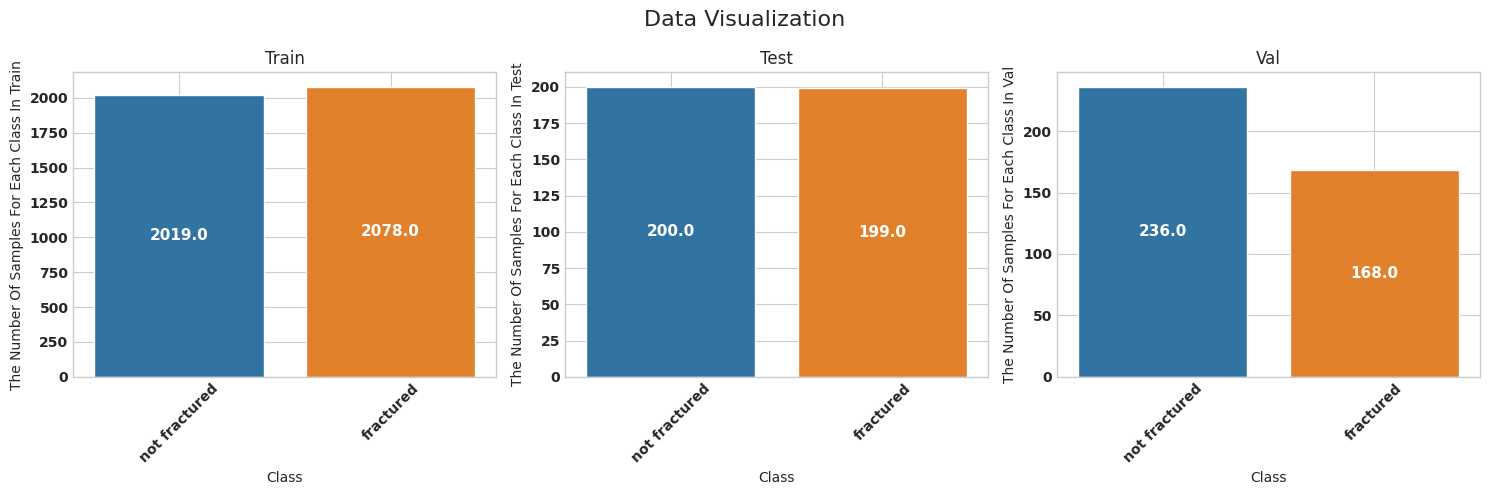

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to add annotations to the bars
def add_counts(ax):
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  
            ax.annotate(f'{height}', 
                        (p.get_x() + p.get_width() / 2., height / 2),  # Position in the middle
                        ha='center', va='center', fontsize=11, color='white')

plt.figure(figsize=(15, 5))
plt.suptitle('Data Visualization', fontsize=16)

# Train plot
plt.subplot(1, 3, 1)
ax1 = sns.countplot(x=train.label)
ax1.set_xlabel("Class")
ax1.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)
add_counts(ax1)

# Test plot
plt.subplot(1, 3, 2)
ax2 = sns.countplot(x=test.label)
ax2.set_xlabel("Class")
ax2.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)
add_counts(ax2)

# Validation plot
plt.subplot(1, 3, 3)
ax3 = sns.countplot(x=val.label)
ax3.set_xlabel("Class")
ax3.set_ylabel("The Number Of Samples For Each Class In Val")
plt.title('Val')
plt.grid(True)
plt.xticks(rotation=45)
add_counts(ax3)

plt.tight_layout()
plt.show()


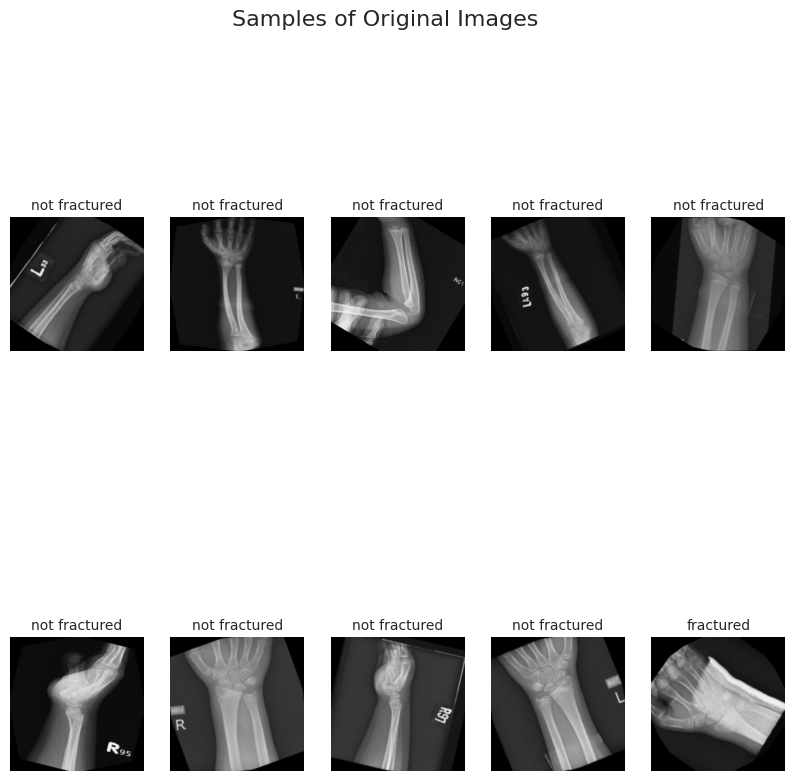

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Assuming 'train' DataFrame has columns 'image' and 'label'

plt.figure(figsize=(10, 10))
for n, i in enumerate(np.random.randint(0, len(train), 10)):
    plt.subplot(2, 5, n + 1)
    img = cv2.imread(train.image[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i], fontsize=10)

# Add a main title
plt.suptitle('Samples of Original Images', fontsize=16)


plt.show()


# **Data Augmentation**

In [8]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 4097 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


# **ResNet50 Model**

In [9]:
from keras.applications import ResNet50V2

model= Sequential()
model.add(ResNet50V2(include_top=False,pooling='avg', weights = 'imagenet' , input_shape=(224,224,3)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

# **Model Training**

In [10]:
checkpoint_cb = ModelCheckpoint("my_keras_model.keras", save_best_only=True)
#early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Compile the model without custom metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[checkpoint_cb])

Epoch 1/10
  1/129 ━━━━━━━━━━━━━━━━━━━━ 34:37 16s/step - accuracy: 0.4062 - loss: 0.8396

I0000 00:00:1716995224.437524     663 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716995224.482957     663 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7810 - loss: 0.4881

W0000 00:00:1716995245.301701     663 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 216ms/step - accuracy: 0.7825 - loss: 0.4850 - val_accuracy: 0.9901 - val_loss: 0.0614
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.9690 - loss: 0.0878 - val_accuracy: 1.0000 - val_loss: 0.0176
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.9943 - loss: 0.0271 - val_accuracy: 1.0000 - val_loss: 0.0077
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.9996 - loss: 0.0107 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9992 - loss: 0.0070 - val_accuracy: 0.9950 - val_loss: 0.0147
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.9989 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 6.7821e-04
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 1.0000 - loss: 0.0020 - val

In [11]:
hist=pd.DataFrame(hist.history)
hist.head()

,accuracy,loss,val_accuracy,val_loss
0,0.878204,0.287700,0.990099,0.061418
1,0.978765,0.066310,1.000000,0.017601
2,0.994142,0.027048,1.000000,0.007665
3,0.999268,0.008817,1.000000,0.003179
4,0.998291,0.010298,0.995049,0.014683


# **Models Evaluation**

In [12]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)

 4/13 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

W0000 00:00:1716995373.670209     665 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 613ms/step


In [13]:
def evaluate_model (test_ds):
    results = model.evaluate(test_ds)
    return results

def evaluations(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return AccScore , PrecisionScore , RecallScore , F1Score


# Calculating Area under the curve
def AUC(actual_class, pred_class, average="micro"):
    # Making a set of all the unique classes
    unique_class = set(actual_class)
    roc_auc_dict = {}
    total_auc = 0  # Variable to store the total AUC score

    for per_class in unique_class:
        # Making a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]

        # Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average=average)
        roc_auc_dict[per_class] = roc_auc
        total_auc += roc_auc

    # Calculating the average AUC score for all classes
    average_auc = total_auc / len(unique_class)

    return roc_auc_dict, average_auc

In [14]:
print("***** Model Evaluations Details ******** \n")
print("Test loss, Test acc : " , evaluate_model(test_generator)) 
print("******************************")
print("Accuracy , Precision ,  Recall , F1 Score : " , evaluations(y_test , y_pred)) 
print("******************************")
roc_auc_dict, average_auc = AUC(y_test, y_pred)
print('AUC Score for each class  : ' , roc_auc_dict)
print("******************************")
print('AUC Average Score   : ' , average_auc)

***** Model Evaluations Details ******** 

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.9953 - loss: 0.0164
Test loss, Test acc :  [0.034575361758470535, 0.9899749159812927]
******************************
Accuracy , Precision ,  Recall , F1 Score :  (0.9899749373433584, 0.9901960784313726, 0.9899497487437185, 0.9899733628185153)
******************************
AUC Score for each class  :  {0: 0.9899497487437185, 1: 0.9899497487437187}
******************************
AUC Average Score   :  0.9899497487437185


In [15]:
from sklearn.metrics import classification_report
labels = ['fractured' , 'not fractured']
print(classification_report(y_test, y_pred, target_names=labels))

               precision    recall  f1-score   support

    fractured       1.00      0.98      0.99       199
not fractured       0.98      1.00      0.99       200

     accuracy                           0.99       399
    macro avg       0.99      0.99      0.99       399
 weighted avg       0.99      0.99      0.99       399



In [16]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (5, 5))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title , weight='bold')
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 90)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('Actual Label' , weight='bold')
	plt.xlabel('Predicted Label' , weight='bold')

In [17]:
def plot_roc_curve(y_test,y_pred):
    
    # Generate predictions

    # Get the true labels from the generator
    true_labels = y_test

    # Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(true_labels, y_pred)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', weight='bold')
    plt.ylabel('True Positive Rate', weight='bold')
    plt.title('(ROC) Curve | Original ResNet50', weight='bold')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()   


# **Graphs**

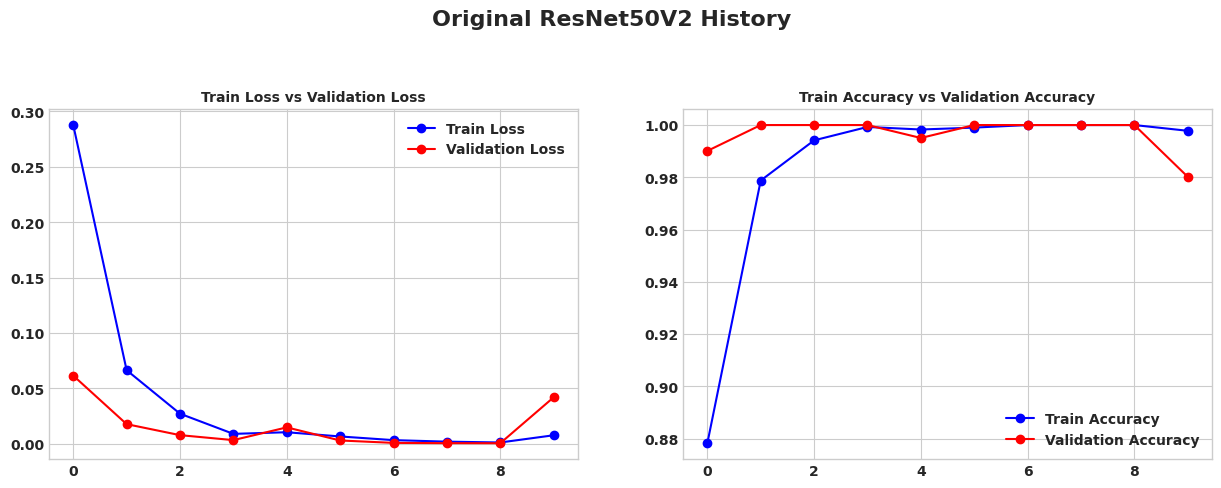

In [18]:
plt.figure(figsize=(15,10))
plt.suptitle('Original ResNet50V2 History', fontsize=16, weight='bold')

plt.subplot(2,2,1)
plt.plot(hist['loss'],'b-o',label='Train Loss')
plt.plot(hist['val_loss'],'r-o',label='Validation Loss')
plt.title('Train Loss vs Validation Loss',fontsize=10, weight='bold')
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist['accuracy'],'b-o',label='Train Accuracy')
plt.plot(hist['val_accuracy'],'r-o',label='Validation Accuracy')
plt.title('Train Accuracy vs Validation Accuracy',fontsize=10, weight='bold')
plt.legend()

plt.show()

Confusion Matrix, Without Normalization
[[195   4]
 [  0 200]]


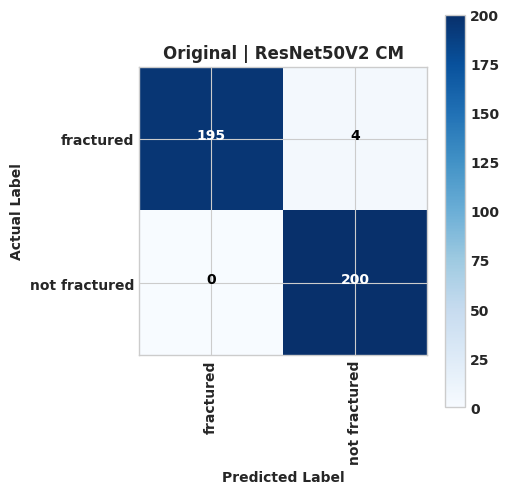

In [19]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plot_confusion_matrix(cm=cm, classes=labels, title='Original | ResNet50V2 CM')

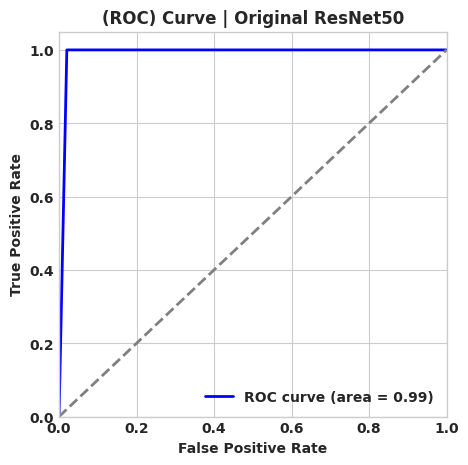

In [20]:
plot_roc_curve(y_test, y_pred)